# S&P500 Trend Model
In this notebook I will pull several economic indicators to use as features in a machine learning model that will attempt to predict monthly S&P500 returns. Successfully predicting whether a given month will have either positive or negative return, I will then build an Algorithmic trading strategy to either buy or short the index using the SPY etf as a proxy.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import os

%matplotlib inline

In [2]:
from dotenv import load_dotenv
load_dotenv()
FRED_KEY = os.getenv("FRED_KEY")

In [3]:
from urllib.request import urlopen
import json

def get_jsonparsed_data(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

# Data Retrieval, Cleaning and Manipulation

In [4]:
# Pulling time series function:
def pull_time_series(time_series_code, dataframe_name):

    url = (f"https://api.stlouisfed.org/fred/series/observations?series_id={time_series_code}&api_key={FRED_KEY}&file_type=json")
    raw_data = get_jsonparsed_data(url)
    dataframe_name = pd.DataFrame(raw_data['observations'])
    
    # convert to datetime
    dataframe_name['Date'] = pd.to_datetime(dataframe_name['date'])
    dataframe_name.set_index('Date', inplace=True)
    dataframe_name = dataframe_name.drop(columns=["date", "realtime_start", "realtime_end"]).sort_index()
    dataframe_name['value'] = pd.to_numeric(dataframe_name['value'],errors='coerce')
    return dataframe_name

In [5]:
# Setting up universal data cleaning functions for FRED Economic data
def clean_data(df,variable_name):
    df.rename(columns={"value":variable_name},inplace=True)
    return df

def pct_change(df,value, time_period):
    df[f'{value}_YoY'] = df[value].pct_change(time_period) * 100
    df[f'{value}_YoY'] = df[f'{value}_YoY'].replace(-np.inf, np.nan).dropna()
    return df

def set_date_to_month_end(df):
    df.index = df.index.to_period('M').to_timestamp('M')
    return df

def resample_monthly(df, variable_name):
    df_resampled = df[variable_name].resample('M').sum()
    df_resampled = pd.DataFrame(df_resampled)
    return df_resampled

In [6]:
# Pull raw data for model
US_GDP_data = pull_time_series("A191RL1Q225SBEA", "US_GDP_Growth")

US_GDP_df = pull_time_series("GDPC1", "REAL_GDP")
US_Real_PCE_data = pull_time_series("PCEC96", "US_Real_PCE")
US_Initial_Claims_data = pull_time_series("ICSA", "US_Initial_Claims")
US_Cap_Util = pull_time_series("TCU", "US_Capital_Utilization")

US_Real_Disposable_Income = pull_time_series("DSPIC96", "Real_Disposable_Personal_Income")
US_Personal_Savings_Rate = pull_time_series("PSAVERT", "US_Personal_Savings_Rate_%_of_DPI")
US_M2_stock = pull_time_series("M2", "M2_Money_Stock")
US_PCE_data = pull_time_series("PCETRIM12M159SFRBDAL", "PCE Inflation Rate")
US_yield_curve = pull_time_series("T10Y2Y", "US 10 Minus 2 Yr Yield")

### Macro Indicators Processing Section

*Note: some of the features listed below here were not in the end added as features in the model.

#### US Real PCE Data (Feature 1 of 10)

In [7]:
# Clean PCE data: feature (1 of 10)
clean_data(US_Real_PCE_data, "Real_PCE")
pct_change(US_Real_PCE_data, "Real_PCE", 12)

# Changing date index to last day of the month
US_Real_PCE_data = set_date_to_month_end(US_Real_PCE_data)

# Drop Na's
US_Real_PCE_data = US_Real_PCE_data.dropna()
US_Real_PCE_data.head()

,Real_PCE,Real_PCE_YoY
Date,,
2003-01-31,9219.1,2.643152
2003-02-28,9186.3,1.821104
2003-03-31,9241.2,2.445514
2003-04-30,9287.2,2.436496
2003-05-31,9308.5,3.063620


#### US Initial Jobless Claims (Feature 2 of 10)

In [8]:
# Clean US Initial Claims data: feature (2 of 10)
clean_data(US_Initial_Claims_data, "Initial_Claims")

# Resample Weekly data to Monthly
US_Initial_Claims_data_resampled = resample_monthly(US_Initial_Claims_data, "Initial_Claims")

# Calculate YoY change
pct_change(US_Initial_Claims_data_resampled, "Initial_Claims", 12)
US_Initial_Claims_data_resampled.tail()

,Initial_Claims,Initial_Claims_YoY
Date,,
2020-05-31,12329000,1312.256586
2020-06-30,5996000,442.624434
2020-07-31,5475000,540.350877
2020-08-31,5161000,377.428307
2020-09-30,3469000,307.159624


#### Capacity Utilization (Feature 3 of 10)

In [231]:
# Clean capacity utilization data: feature (3 of 10)
clean_data(US_Cap_Util, "Capacity_Utilization")

# Calculate YoY Change
pct_change(US_Cap_Util, "Capacity_Utilization", 12)

# Changing date index to last day of the month
US_Cap_Util = set_date_to_month_end(US_Cap_Util)

US_Cap_Util.tail(10)

,Capacity_Utilization,Capacity_Utilization_YoY
Date,,
2019-11-30,77.5723,-2.513682
2019-12-31,77.1697,-2.885386
2020-01-31,76.8754,-2.695033
2020-02-29,76.9258,-1.953392
2020-03-31,73.5576,-6.174855
2020-04-30,64.0552,-17.629041
2020-05-31,64.6990,-16.834414
2020-06-30,68.6926,-11.586505
2020-07-31,71.1399,-8.116476


#### US Personal Savings Rate (Feature 4 of 10)

In [10]:
# Clean US_Personal_Savings_Rate data: feature (4 of 10)

clean_data(US_Personal_Savings_Rate, "US_Personal_Savings_Rate_%_of_DPI")

# Calculate YoY Change
pct_change(US_Personal_Savings_Rate, "US_Personal_Savings_Rate_%_of_DPI", 12)

# Changing date index to last day of the month
US_Personal_Savings_Rate_df = set_date_to_month_end(US_Personal_Savings_Rate)

US_Personal_Savings_Rate_df.tail(20)

,US_Personal_Savings_Rate_%_of_DPI,US_Personal_Savings_Rate_%_of_DPI_YoY
Date,,
2019-01-31,8.5,13.333333
2019-02-28,8.6,10.256410
2019-03-31,8.0,2.564103
2019-04-30,7.5,-2.597403
2019-05-31,7.3,-5.194805
2019-06-30,7.1,-10.126582
2019-07-31,7.0,-11.392405
2019-08-31,7.3,-6.410256
2019-09-30,7.3,-7.594937


#### US Real Disposable Income (Feature 5 of 10)

In [233]:
# Clean US_Real_Disposable_Income data: feature (5 of 10)

clean_data(US_Real_Disposable_Income, "US_Real_DPI")

# Calculate YoY Change
pct_change(US_Real_Disposable_Income, "US_Real_DPI", 12)

# Changing date index to last day of the month
US_Real_Disposable_Income_df = set_date_to_month_end(US_Real_Disposable_Income)

US_Real_Disposable_Income_df.tail(10)

,US_Real_DPI,US_Real_DPI_YoY
Date,,
2019-11-30,14997.2,2.098864
2019-12-31,14960.2,0.828318
2020-01-31,15070.2,1.545055
2020-02-29,15162.6,2.008194
2020-03-31,14949.3,0.630061
2020-04-30,17259.4,16.482196
2020-05-31,16397.9,10.724800
2020-06-30,16070.5,8.388189
2020-07-31,16064.7,8.250507


#### US M2 Money Stock (Feature 6 of 10)

In [12]:
# Clean M2 Money stock data: feature (6 of 10)
clean_data(US_M2_stock, "M2")

# Resample Weekly data to Monthly (not using resampling function here as we don't want to sum weekly figures, we just want the last figure)
M2_stock_resampled = US_M2_stock.resample('M').last()

# Calculate YoY change
pct_change(M2_stock_resampled, "M2", 12)

M2_stock_resampled.tail(13)

,M2,M2_YoY
Date,,
2019-09-30,15086.4,5.975077
2019-10-31,15189.1,6.605138
2019-11-30,15282.4,7.193760
2019-12-31,15333.6,6.388027
2020-01-31,15445.3,6.724663
2020-02-29,15434.1,6.653169
2020-03-31,16533.3,13.860213
2020-04-30,17406.5,19.313314
2020-05-31,17938.6,22.058693


#### US PCE Inflation Rate (Feature 7 of 10)

In [13]:
# Clean PCE data: feature (7 of 10)
clean_data(US_PCE_data, "Inflation Rate")

# Changing date index to last day of the month
US_PCE_data = set_date_to_month_end(US_PCE_data)
US_PCE_data.isnull().sum()

Inflation Rate    0
dtype: int64

#### US 10-2 YR Treasury Yield Spread (Feature 8 of 10)

In [230]:
# Clean Yield Curve data: feature (8 of 10)
clean_data(US_yield_curve, "10yr minus 2yr yield")

# Construct the dependent variable where if monthly return is greater than 0, then 1, else, 0.
US_yield_curve['Inversion Signal'] = np.where(US_yield_curve['10yr minus 2yr yield'] <= 0, 1.0, 0.0)

# Clean Yield Curve data 
US_yield_curve = US_yield_curve.resample('M').agg({'10yr minus 2yr yield':'last', 'Inversion Signal':np.any})

US_yield_curve.tail(20)

,10yr minus 2yr yield,Inversion Signal
Date,,
2019-03-31,0.14,False
2019-04-30,0.24,False
2019-05-31,0.19,False
2019-06-30,0.25,False
2019-07-31,0.13,False
2019-08-31,0.00,True
2019-09-30,0.05,False
2019-10-31,0.17,False
2019-11-30,0.17,False


In [15]:
# Final US yield curve data
US_yield_curve["Inversion Signal"] = US_yield_curve["Inversion Signal"].astype(int)

In [16]:
US_yield_curve.tail(20)

,10yr minus 2yr yield,Inversion Signal
Date,,
2019-03-31,0.14,0
2019-04-30,0.24,0
2019-05-31,0.19,0
2019-06-30,0.25,0
2019-07-31,0.13,0
2019-08-31,0.00,1
2019-09-30,0.05,0
2019-10-31,0.17,0
2019-11-30,0.17,0


#### VIX Index - Volatility Signal (Feature 9 of 10)

In [17]:
#Download stock data function:
def download_data(tickers, start_date):
    stock_data = yf.download(tickers,start=start_date)
    stock_data = stock_data.drop(columns=["Close", "High", "Low", "Open", "Volume"])
    stock_data["Adj Close"] = stock_data['Adj Close'].astype(float)
    stock_data = stock_data.dropna()
    return stock_data

In [18]:
# Download VIX data
VIX_df = download_data(['^VIX'], "1980-01-01")
VIX_df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1990-01-02,17.240000
1990-01-03,18.190001
1990-01-04,19.219999
1990-01-05,20.110001
1990-01-08,20.260000


In [19]:
# Clean Vix DF data and calculate monthly returns
VIX_resampled = VIX_df.resample('M').last()
VIX_resampled["VIX Monthly Return"] = VIX_resampled['Adj Close'].pct_change() * 100
VIX_resampled = VIX_resampled.dropna()
VIX_resampled["Vol Signal"] = np.where(VIX_resampled['Adj Close'] < VIX_resampled['Adj Close'].shift(1), 1.0,0.0)
VIX_resampled.tail(20)

,Adj Close,VIX Monthly Return,Vol Signal
Date,,,
2019-03-31,13.710000,-7.239511,1.0
2019-04-30,13.120000,-4.303429,1.0
2019-05-31,18.709999,42.606702,0.0
2019-06-30,15.080000,-19.401386,1.0
2019-07-31,16.120001,6.896558,0.0
2019-08-31,18.980000,17.741927,0.0
2019-09-30,16.240000,-14.436248,1.0
2019-10-31,13.220000,-18.596056,1.0
2019-11-30,12.620000,-4.538581,1.0


#### Industrials Basket of Stocks (Feature 10 of 10)

In [20]:
# Download Industrials Stock data
industrials_df = download_data(['FDX','UNP','HON','LMT','MMM'], "1980-01-01")
industrials_df.head()

[*********************100%***********************]  5 of 5 completed


Adj Close                                        
                 FDX       HON       LMT       MMM       UNP
Date                                                        
1980-01-02  2.484676  0.724475  1.165170  0.470189  0.016732
1980-01-03  2.539890  0.709223  1.239636  0.451192  0.016499
1980-01-04  2.691732  0.716849  1.331624  0.451192  0.016790
1980-01-07  2.719339  0.714943  1.406089  0.453567  0.016703
1980-01-08  2.815966  0.732101  1.533118  0.470189  0.016090

In [21]:
# Clean Industrials Stock data and calculate monthly returns
industrials_resampled = industrials_df.resample('M').last()

# This drops the upper 'Adj Close' level in the dataframe
industrials_resampled = industrials_resampled.droplevel(0, axis=1)

# This is a function to calculate monthly percentage returns, which we will then apply to each stock
def monthly_return(df):
    df = df.pct_change() * 100
    df = df.dropna()
    return df

industrials_resampled = industrials_resampled.apply(monthly_return)
# Calculate an average return for all stocks
industrials_resampled["Average Industrials Stock Return"] = industrials_resampled.mean(axis=1)
industrials_resampled.tail(20)

,FDX,HON,LMT,MMM,UNP,Average Industrials Stock Return
Date,,,,,,
2019-03-31,0.604836,3.147898,-2.989554,0.188053,-0.298160,0.130615
2019-04-30,4.437454,9.256246,11.050750,-8.792956,5.885165,4.367332
2019-05-31,-18.568562,-4.907191,2.220663,-14.982400,-5.302187,-8.307935
2019-06-30,6.835520,6.256465,7.384648,8.507041,1.397048,6.076144
2019-07-31,3.861360,-1.219996,-0.376847,0.796116,6.410027,1.894132
2019-08-31,-6.989976,-4.066439,6.668356,-6.593513,-9.442659,-4.084846
2019-09-30,-7.857066,2.782154,1.549042,1.657173,0.012327,-0.371274
2019-10-31,4.870527,2.086299,-3.430244,0.358891,2.148435,1.206782
2019-11-30,4.840813,3.883280,4.445434,3.787981,6.946569,4.780815


#### Pulling USD monthly returns

In [22]:
# Download USD returns
USD_df = download_data(['DX-Y.NYB'], "1980-01-01")
USD_df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1980-01-02,85.320000
1980-01-03,85.260002
1980-01-04,85.230003
1980-01-07,84.790001
1980-01-08,85.070000


In [23]:
# Clean USD data and calculate monthly returns
USD_resampled = USD_df.resample('M').last()
USD_resampled["USD Monthly Return"] = USD_resampled['Adj Close'].pct_change() * 100
USD_resampled = USD_resampled.dropna()
USD_resampled.tail(20)

,Adj Close,USD Monthly Return
Date,,
2019-03-31,97.279999,1.164720
2019-04-30,97.480003,0.205597
2019-05-31,97.790001,0.318011
2019-06-30,96.129997,-1.697519
2019-07-31,98.519997,2.486216
2019-08-31,98.919998,0.406010
2019-09-30,99.379997,0.465021
2019-10-31,97.349998,-2.042663
2019-11-30,98.410004,1.088860


#### Pulling JPY vs EUR monthly returns

In [24]:
# Pull JPY prices
JPY_df = download_data(['JPYEUR=X'], "1980-01-01")
JPY_df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2005-09-16,0.00734
2005-09-19,0.00739
2005-09-20,0.00737
2005-09-22,0.00737
2005-09-23,0.00738


#### S&P500 Price and Returns
SPY etf is used as proxy for SP500 returns. Monthly SPY returns will be our y-variable for our model and will be used as our benchmark for for algorithmic trading strategy.

In [25]:
# Download SPY (SP500) Prices
SP500_df = download_data(["SPY"], "1993-01-01")
SP500_df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
1993-01-29,26.079659
1993-02-01,26.265144
1993-02-02,26.320782
1993-02-03,26.599014
1993-02-04,26.710312


In [26]:
# Clean SPY data and calculate monthly returns
SPY_resampled = SP500_df.resample('M').last()
SPY_resampled["Monthly Return"] = SPY_resampled['Adj Close'].pct_change() * 100
SPY_resampled = SPY_resampled.dropna()
SPY_resampled.tail()

,Adj Close,Monthly Return
Date,,
2020-06-30,307.130554,1.773441
2020-07-31,325.218140,5.889217
2020-08-31,347.917297,6.979671
2020-09-30,334.890015,-3.744362
2020-10-31,336.970001,0.621095


### Concating DataFrames

In [175]:
# Not including Real PCE data for now, as data only goes back to 2003
master_df = pd.concat([SPY_resampled,
                       US_Initial_Claims_data_resampled, 
                       US_Cap_Util,
                       US_Real_Disposable_Income,
                       US_Personal_Savings_Rate, 
                       M2_stock_resampled, 
                       US_PCE_data, 
                       US_yield_curve, 
                       industrials_resampled["Average Industrials Stock Return"],
                       VIX_resampled["Vol Signal"], 
                       USD_resampled], axis="columns", join='inner')
master_df.tail()

,Adj Close,Monthly Return,Initial_Claims,Initial_Claims_YoY,Capacity_Utilization,Capacity_Utilization_YoY,US_Real_DPI,US_Real_DPI_YoY,US_Personal_Savings_Rate_%_of_DPI,US_Personal_Savings_Rate_%_of_DPI_YoY,M2,M2_YoY,Inflation Rate,10yr minus 2yr yield,Inversion Signal,Average Industrials Stock Return,Vol Signal,Adj Close,USD Monthly Return
Date,,,,,,,,,,,,,,,,,,,
2020-04-30,288.054260,12.698352,20161000,2238.863109,64.0552,-17.629041,17259.4,16.482196,33.6,348.000000,17406.5,19.313314,1.87,0.44,0,9.994442,1.0,99.019997,0.070742
2020-05-31,301.778687,4.764528,12329000,1312.256586,64.6990,-16.834414,16397.9,10.724800,24.5,235.616438,17938.6,22.058693,1.92,0.49,0,3.574383,1.0,98.339996,-0.686730
2020-06-30,307.130554,1.773441,5996000,442.624434,68.6926,-11.586505,16070.5,8.388189,18.7,163.380282,18233.6,23.215818,1.87,0.50,0,0.048521,0.0,97.389999,-0.966033
2020-07-31,325.218140,5.889217,5475000,540.350877,71.1399,-8.116476,16064.7,8.250507,17.7,152.857143,18284.5,22.685123,1.86,0.44,0,5.249169,1.0,93.489998,-4.004520
2020-08-31,347.917297,6.979671,5161000,377.428307,71.4197,-8.244065,15502.6,3.957780,14.1,93.150685,18464.5,23.605923,1.92,0.58,0,13.301709,0.0,92.139999,-1.444003


### Building the Model

In [176]:
# Set up an industrials stock signal, where 1 is a sell signal = S&P500 outperforms industrials, and 0 is a buy signal 
master_df['Industrials Stock Signal'] = np.where(master_df['Monthly Return'] > master_df["Average Industrials Stock Return"], 1.0, 0.0)
master_df.head()


,Adj Close,Monthly Return,Initial_Claims,Initial_Claims_YoY,Capacity_Utilization,Capacity_Utilization_YoY,US_Real_DPI,US_Real_DPI_YoY,US_Personal_Savings_Rate_%_of_DPI,US_Personal_Savings_Rate_%_of_DPI_YoY,M2,M2_YoY,Inflation Rate,10yr minus 2yr yield,Inversion Signal,Average Industrials Stock Return,Vol Signal,Adj Close,USD Monthly Return,Industrials Stock Signal
Date,,,,,,,,,,,,,,,,,,,,
1993-02-28,26.357893,1.066864,1353000,-38.805970,81.6255,2.354933,7257.7,2.452005,8.9,-9.183673,3415.7,0.387950,2.51,2.11,0,7.008603,0.0,94.050003,1.719667,0.0
1993-03-31,26.948282,2.239895,1404000,-18.277066,81.3902,1.424475,7235.1,2.022082,8.9,-8.247423,3409.7,0.252859,2.45,2.07,0,4.048744,1.0,91.870003,-2.317916,0.0
1993-04-30,26.258728,-2.558806,1419000,-15.182307,81.5609,1.084953,7272.7,2.246622,8.7,-12.121212,3411.1,0.344178,2.52,2.22,0,-3.228551,1.0,89.489998,-2.590622,1.0
1993-05-31,26.966932,2.697024,1718000,-17.680882,81.1656,0.484934,7262.2,1.610443,8.3,-16.161616,3445.5,1.427730,2.57,1.92,0,1.945604,0.0,89.080002,-0.458147,1.0
1993-06-30,27.064190,0.360655,1371000,-18.149254,81.1872,0.718289,7248.8,0.989161,7.8,-22.772277,3438.2,1.448762,2.53,1.77,0,0.229861,1.0,93.629997,5.107763,1.0


In [177]:
# Set x variable list of features
# Currently commenting out features that generalized poorly in the model
x_var_list = ['Initial_Claims_YoY', 
              'Capacity_Utilization_YoY', 
              'US_Real_DPI_YoY', 
              #'US_Personal_Savings_Rate_%_of_DPI_YoY', 
              'M2_YoY', 
              'Inflation Rate', 
              'Inversion Signal', 
              #'Industrials Stock Signal', 
              #'USD Monthly Return', 
              'Vol Signal'
             ]

# Filter by x-variable list
master_df[x_var_list].tail()


,Initial_Claims_YoY,Capacity_Utilization_YoY,US_Real_DPI_YoY,M2_YoY,Inflation Rate,Inversion Signal,Vol Signal
Date,,,,,,,
2020-04-30,2238.863109,-17.629041,16.482196,19.313314,1.87,0,1.0
2020-05-31,1312.256586,-16.834414,10.724800,22.058693,1.92,0,1.0
2020-06-30,442.624434,-11.586505,8.388189,23.215818,1.87,0,0.0
2020-07-31,540.350877,-8.116476,8.250507,22.685123,1.86,0,1.0
2020-08-31,377.428307,-8.244065,3.957780,23.605923,1.92,0,0.0


In [178]:
# Shift DataFrame values by 1 = this will shift data points forward one month so that we are using previous months data to predict current month y variable.
master_df[x_var_list] = master_df[x_var_list].shift(1)
master_df[x_var_list].tail()

,Initial_Claims_YoY,Capacity_Utilization_YoY,US_Real_DPI_YoY,M2_YoY,Inflation Rate,Inversion Signal,Vol Signal
Date,,,,,,,
2020-04-30,879.522498,-6.174855,0.630061,13.860213,1.98,0.0,0.0
2020-05-31,2238.863109,-17.629041,16.482196,19.313314,1.87,0.0,1.0
2020-06-30,1312.256586,-16.834414,10.724800,22.058693,1.92,0.0,1.0
2020-07-31,442.624434,-11.586505,8.388189,23.215818,1.87,0.0,0.0
2020-08-31,540.350877,-8.116476,8.250507,22.685123,1.86,0.0,1.0


In [179]:
# Drop NAs and replace positive/negative infinity values
master_df.dropna(subset=x_var_list, inplace=True)
master_df = master_df.replace([np.inf, -np.inf], np.nan)
master_df.head()

,Adj Close,Monthly Return,Initial_Claims,Initial_Claims_YoY,Capacity_Utilization,Capacity_Utilization_YoY,US_Real_DPI,US_Real_DPI_YoY,US_Personal_Savings_Rate_%_of_DPI,US_Personal_Savings_Rate_%_of_DPI_YoY,M2,M2_YoY,Inflation Rate,10yr minus 2yr yield,Inversion Signal,Average Industrials Stock Return,Vol Signal,Adj Close,USD Monthly Return,Industrials Stock Signal
Date,,,,,,,,,,,,,,,,,,,,
1993-03-31,26.948282,2.239895,1404000,-38.805970,81.3902,2.354933,7235.1,2.452005,8.9,-8.247423,3409.7,0.387950,2.51,2.07,0.0,4.048744,0.0,91.870003,-2.317916,0.0
1993-04-30,26.258728,-2.558806,1419000,-18.277066,81.5609,1.424475,7272.7,2.022082,8.7,-12.121212,3411.1,0.252859,2.45,2.22,0.0,-3.228551,1.0,89.489998,-2.590622,1.0
1993-05-31,26.966932,2.697024,1718000,-15.182307,81.1656,1.084953,7262.2,2.246622,8.3,-16.161616,3445.5,0.344178,2.52,1.92,0.0,1.945604,1.0,89.080002,-0.458147,1.0
1993-06-30,27.064190,0.360655,1371000,-17.680882,81.1872,0.484934,7248.8,1.610443,7.8,-22.772277,3438.2,1.427730,2.57,1.77,0.0,0.229861,0.0,93.629997,5.107763,1.0
1993-07-31,26.932825,-0.485382,1754000,-18.149254,81.3220,0.718289,7267.1,0.989161,7.6,-20.833333,3442.3,1.448762,2.53,1.70,0.0,4.284616,1.0,95.370003,1.858385,0.0


In [180]:
# Set up new dataframe with just x-features and y variable
# Once again commenting out features that generalized poorly in the model
new_df_list = ['Monthly Return',
               'Initial_Claims_YoY', 
               'Capacity_Utilization_YoY', 
               'US_Real_DPI_YoY', 
               #'US_Personal_Savings_Rate_%_of_DPI_YoY', 
               'M2_YoY', 
               'Inflation Rate', 
               'Inversion Signal', 
               #'Industrials Stock Signal', 
               #'USD Monthly Return',
               'Vol Signal'
              ]
new_df = master_df[new_df_list]
new_df.tail()

,Monthly Return,Initial_Claims_YoY,Capacity_Utilization_YoY,US_Real_DPI_YoY,M2_YoY,Inflation Rate,Inversion Signal,Vol Signal
Date,,,,,,,,
2020-04-30,12.698352,879.522498,-6.174855,0.630061,13.860213,1.98,0.0,0.0
2020-05-31,4.764528,2238.863109,-17.629041,16.482196,19.313314,1.87,0.0,1.0
2020-06-30,1.773441,1312.256586,-16.834414,10.724800,22.058693,1.92,0.0,1.0
2020-07-31,5.889217,442.624434,-11.586505,8.388189,23.215818,1.87,0.0,0.0
2020-08-31,6.979671,540.350877,-8.116476,8.250507,22.685123,1.86,0.0,1.0


In [181]:
# Construct the dependent variable where if monthly return is greater than 0, then 1, else, 0.
new_df['Monthly Return'] = np.where(new_df['Monthly Return'] > 0, 1.0, 0.0)
new_df.tail()

C:\Users\savag\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Monthly Return,Initial_Claims_YoY,Capacity_Utilization_YoY,US_Real_DPI_YoY,M2_YoY,Inflation Rate,Inversion Signal,Vol Signal
Date,,,,,,,,
2020-04-30,1.0,879.522498,-6.174855,0.630061,13.860213,1.98,0.0,0.0
2020-05-31,1.0,2238.863109,-17.629041,16.482196,19.313314,1.87,0.0,1.0
2020-06-30,1.0,1312.256586,-16.834414,10.724800,22.058693,1.92,0.0,1.0
2020-07-31,1.0,442.624434,-11.586505,8.388189,23.215818,1.87,0.0,0.0
2020-08-31,1.0,540.350877,-8.116476,8.250507,22.685123,1.86,0.0,1.0


In [182]:
new_df['Monthly Return'].value_counts()

1.0    215
0.0    115
Name: Monthly Return, dtype: int64

#### Split data into training and test sets

In [183]:
# Calculate the 70 percentile to split data into train/test
print(len(new_df))
329*0.7
new_df.iloc[231]

330


Monthly Return               1.000000
Initial_Claims_YoY         -11.597633
Capacity_Utilization_YoY     1.830157
US_Real_DPI_YoY              3.763472
M2_YoY                       9.524125
Inflation Rate               1.930000
Inversion Signal             0.000000
Vol Signal                   0.000000
Name: 2012-06-30 00:00:00, dtype: float64

In [184]:
# Construct training start and end dates
training_start = new_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2012-06-30'

# Construct testing start and end dates
testing_start =  '2012-07-31'
testing_end = new_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 1993-03-31
Training End: 2012-06-30
Testing Start: 2012-07-31
Testing End: 2020-08-31


In [185]:
# Construct the x train and y train datasets
X_train = new_df[x_var_list][training_start:training_end]
y_train = new_df['Monthly Return'][training_start:training_end]


In [186]:
# Construct the x test and y test datasets
X_test = new_df[x_var_list][testing_start:testing_end]
y_test = new_df['Monthly Return'][testing_start:testing_end]

y_test.tail()

Date
2020-04-30    1.0
2020-05-31    1.0
2020-06-30    1.0
2020-07-31    1.0
2020-08-31    1.0
Freq: M, Name: Monthly Return, dtype: float64

#### Scale the data

In [187]:
# Scaling data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [188]:
X_train_scaled

array([[0.        , 0.69057434, 0.52408781, ..., 0.83574879, 0.        ,
        0.        ],
       [0.13697252, 0.65571111, 0.47267941, ..., 0.80676329, 0.        ,
        1.        ],
       [0.1576213 , 0.64298959, 0.49952903, ..., 0.84057971, 0.        ,
        1.        ],
       ...,
       [0.34478769, 0.63935549, 0.58747086, ..., 0.59903382, 0.        ,
        1.        ],
       [0.07617311, 0.67627396, 0.6578129 , ..., 0.58937198, 0.        ,
        0.        ],
       [0.18153889, 0.67091157, 0.68090787, ..., 0.55555556, 0.        ,
        0.        ]])

### Random Forest Model

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [190]:
# Fit a SKLearn RF model using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=30, max_depth=4, random_state=0)
model.fit(X_train_scaled, y_train)

# Make predictions of y values from the x test dataset
predictions = model.predict(X_test_scaled)

# Assemble actual y data (Y_test) with predicted y data into two columns in a dataframe to compare:
Results = y_test.to_frame()
Results["Random Forest Predicted Value"] = predictions
Results

,Monthly Return,Random Forest Predicted Value
Date,,
2012-07-31,1.0,1.0
2012-08-31,1.0,1.0
2012-09-30,1.0,1.0
2012-10-31,0.0,1.0
2012-11-30,1.0,1.0
...,...,...
2020-04-30,1.0,1.0
2020-05-31,1.0,1.0
2020-06-30,1.0,1.0


In [191]:
# Function to print a confusion matrix:
def cm_to_df(cm, model_title):
    print(f"Confusion Matrix - {model_title}")
    cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Predicted Negative", "Predicted Positive"])
    return cm_df

In [192]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm_to_df(cm, "Random Forest Classifier Confusion Matrix")

Confusion Matrix - Random Forest Classifier Confusion Matrix


,Predicted Negative,Predicted Positive
Negative,2,23
Positive,4,69


In [193]:
print("Test set accuracy: {:.2f}".format(model.score(X_test_scaled, y_test)))

Test set accuracy: 0.72


In [194]:
print("Test set predictions:", predictions)

Test set predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1.]


In [195]:
# List the features sorted in descending order by feature importance
important_features = model.feature_importances_

sorted(zip(model.feature_importances_, new_df[x_var_list]), reverse=True)

[(0.2645242992862643, 'M2_YoY'),
 (0.20897310950933237, 'Inflation Rate'),
 (0.20814385048123946, 'US_Real_DPI_YoY'),
 (0.15876793937262537, 'Initial_Claims_YoY'),
 (0.12595510549503489, 'Capacity_Utilization_YoY'),
 (0.028942292019955882, 'Vol Signal'),
 (0.004693403835547738, 'Inversion Signal')]

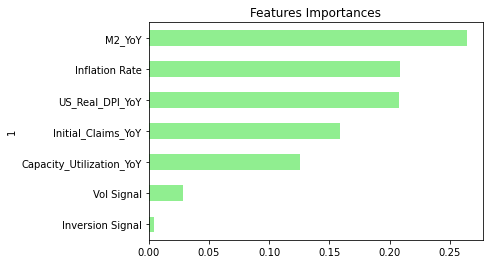

In [196]:
# Visualize the features by their importance to the model
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, new_df[x_var_list]), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [197]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.33      0.08      0.95      0.13      0.27      0.07        25
        1.0       0.75      0.95      0.08      0.84      0.27      0.08        73

avg / total       0.64      0.72      0.30      0.66      0.27      0.08        98



In [198]:
## The range of values of MCC lie between -1 to +1.
#A model with a score of +1 is a perfect model and -1 is a poor model.
#Similarly to F1 score (Fi score considers TP, FP FN- does not take into account true negative.
#So F1 score is very sensitive to what is called negative but MCC is not
#so MCC actually gives you a better idea of what is going on in your data)

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions)


0.045830738822372985

### Logistic Regression

In [199]:
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression(solver='lbfgs', random_state=1)
model_logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1)

In [200]:
# Make predictions on X-test data:
predictions_logreg = model_logreg.predict(X_test_scaled)

# Display the confusion matrix:
cm_3 = confusion_matrix(y_test, predictions_logreg)
cm_to_df(cm_3, "Logistic Regression Confusion Matrix")

Confusion Matrix - Logistic Regression Confusion Matrix


,Predicted Negative,Predicted Positive
Negative,0,25
Positive,5,68


In [201]:
print("Test set accuracy: {:.2f}".format(model_logreg.score(X_test_scaled, y_test)))

Test set accuracy: 0.69


In [202]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions_logreg))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.00      0.00      0.93      0.00      0.00      0.00        25
        1.0       0.73      0.93      0.00      0.82      0.00      0.00        73

avg / total       0.54      0.69      0.24      0.61      0.00      0.00        98



In [203]:
## The range of values of MCC lie between -1 to +1.
#A model with a score of +1 is a perfect model and -1 is a poor model.
#Similarly to F1 score (Fi score considers TP, FP FN- does not take into account true negative.
#So F1 score is very sensitive to what is called negative but MCC is not
#so MCC actually gives you a better idea of what is going on in your data)

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions_logreg)

-0.13569133089809227

### Smote Oversampling

In [204]:
# Resample the training data with SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE


X_resampled_2, y_resampled_2 = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train_scaled, y_train
)

Counter(y_resampled_2)

Counter({1.0: 142, 0.0: 142})

In [205]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model_smote = LogisticRegression(solver='lbfgs', random_state=1)
model_smote.fit(X_resampled_2, y_resampled_2)

LogisticRegression(random_state=1)

In [206]:
# Make predictions using X-test data:
predictions_smote = model_smote.predict(X_test_scaled)

# Display the confusion matrix
cm_3 = confusion_matrix(y_test, predictions_smote)
cm_to_df(cm_3, "SMOTE Algorithm Confusion Matrix")

Confusion Matrix - SMOTE Algorithm Confusion Matrix


,Predicted Negative,Predicted Positive
Negative,14,11
Positive,38,35


In [207]:
print("Test set accuracy: {:.2f}".format(model_smote.score(X_test_scaled, y_test)))

Test set accuracy: 0.50


In [208]:
## The range of values of MCC lie between -1 to +1.
#A model with a score of +1 is a perfect model and -1 is a poor model.
#Similarly to F1 score (Fi score considers TP, FP FN- does not take into account true negative.
#So F1 score is very sensitive to what is called negative but MCC is not
#so MCC actually gives you a better idea of what is going on in your data)

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions_smote)

0.03446041270765955

### Random Forest (with Oversampling)

In [209]:
# Fit a SKLearn RF model using just the training set (X_train, Y_train):
model_rf_resample = RandomForestClassifier(n_estimators=30, max_depth=3, random_state=0)
model_rf_resample.fit(X_resampled_2, y_resampled_2)

# Make predictions of y values from the x test dataset
predictions_rf_resample = model_rf_resample.predict(X_test_scaled)

# # Assemble actual y data (Y_test) with predicted y data into two columns in a dataframe to compare:
# Results = y_test.to_frame()
# Results["Random Forest Oversampling Predicted Value"] = predictions_rf_resample
# Results

In [210]:
# Display the confusion matrix
cm_rf_resample = confusion_matrix(y_test, predictions_rf_resample)
cm_to_df(cm_rf_resample, "SMOTE/RF Algorithm Confusion Matrix")

Confusion Matrix - SMOTE/RF Algorithm Confusion Matrix


,Predicted Negative,Predicted Positive
Negative,9,16
Positive,27,46


In [211]:
## The range of values of MCC lie between -1 to +1.
#A model with a score of +1 is a perfect model and -1 is a poor model.
#Similarly to F1 score (Fi score considers TP, FP FN- does not take into account true negative.
#So F1 score is very sensitive to what is called negative but MCC is not
#so MCC actually gives you a better idea of what is going on in your data)

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions_rf_resample)

-0.008918544334893943

In [212]:
print("Test set accuracy: {:.2f}".format(model_rf_resample.score(X_test_scaled, y_test)))

Test set accuracy: 0.56


In [213]:
# List the features sorted in descending order by feature importance
important_features = model_rf_resample.feature_importances_

sorted(zip(model_rf_resample.feature_importances_, new_df[x_var_list]), reverse=True)

[(0.2709617238214397, 'M2_YoY'),
 (0.26086232507754004, 'Inflation Rate'),
 (0.23983282738509687, 'US_Real_DPI_YoY'),
 (0.10613190986567762, 'Initial_Claims_YoY'),
 (0.0921877980162559, 'Capacity_Utilization_YoY'),
 (0.018314063020904752, 'Inversion Signal'),
 (0.011709352813085177, 'Vol Signal')]

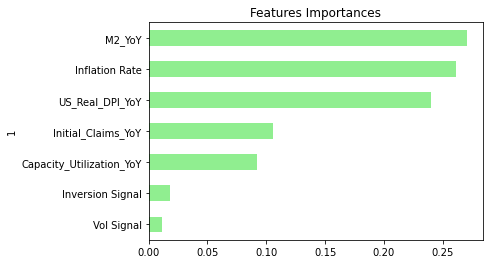

In [214]:
# Visualize the features by their importance to the model
importances_df = pd.DataFrame(sorted(zip(model_rf_resample.feature_importances_, new_df[x_var_list]), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

### Gradient Boosting

In [215]:
# Choose a learning rate and create classifier
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(n_estimators=20,
                                        learning_rate=0.63,
                                        max_features=5,
                                        random_state=0)

# Fit the model
classifier.fit(X_train_scaled, y_train.ravel())

GradientBoostingClassifier(learning_rate=0.63, max_features=5, n_estimators=20,
                           random_state=0)

In [216]:
# Make Prediction
predictions_gradient = classifier.predict(X_test_scaled)

# Display confusion matrix
cm_3 = confusion_matrix(y_test, predictions_gradient)
cm_to_df(cm_3, "Gradient Boosting Algorithm Confusion Matrix")

Confusion Matrix - Gradient Boosting Algorithm Confusion Matrix


,Predicted Negative,Predicted Positive
Negative,4,21
Positive,17,56


In [217]:
print("Test set accuracy: {:.2f}".format(classifier.score(X_test_scaled, y_test)))

Test set accuracy: 0.61


In [218]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions_gradient))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.19      0.16      0.77      0.17      0.35      0.12        25
        1.0       0.73      0.77      0.16      0.75      0.35      0.13        73

avg / total       0.59      0.61      0.31      0.60      0.35      0.13        98



In [219]:
## The range of values of MCC lie between -1 to +1.
#A model with a score of +1 is a perfect model and -1 is a poor model.
#Similarly to F1 score (Fi score considers TP, FP FN- does not take into account true negative.
#So F1 score is very sensitive to what is called negative but MCC is not
#so MCC actually gives you a better idea of what is going on in your data)

from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, predictions_gradient)

-0.07742214450621918

### Algo Trading Strategy

Here I will build the Algorithmic Trading Strategy using the Machine Learning Models above to inform our buy/sell decisions.
We will focus on just three ML models compile above: (i) Random Forest Model; (ii) SMOTE (Logistic Regression) Model; (iii) Gradient Boosting Classifier Model

In [220]:
# Display the Predicted values for all the Machine Learning Models above:
Results["Percentage Return"] = master_df['Monthly Return']/100
#Results["Logistic Regression Predicted Value"] = predictions_logreg
Results["SMOTE Predicted Value"] = predictions_smote
Results["Gradient Boost Predicted Value"] = predictions_gradient
#Results["Random Forest Model/Oversampling Predicted Value"] = predictions_rf_resample

Results.head(20)

,Monthly Return,Random Forest Predicted Value,Percentage Return,SMOTE Predicted Value,Gradient Boost Predicted Value
Date,,,,,
2012-07-31,1.0,1.0,0.011829,0.0,1.0
2012-08-31,1.0,1.0,0.025052,0.0,1.0
2012-09-30,1.0,1.0,0.025351,1.0,1.0
2012-10-31,0.0,1.0,-0.018198,1.0,1.0
2012-11-30,1.0,1.0,0.005660,0.0,1.0
2012-12-31,1.0,1.0,0.008934,1.0,1.0
2013-01-31,1.0,1.0,0.051190,0.0,0.0
2013-02-28,1.0,1.0,0.012759,0.0,1.0
2013-03-31,1.0,1.0,0.037972,0.0,1.0


In [221]:
# Replace predicted values 0 to -1 to account for shorting
Results['Random Forest Predicted Value'].replace(0, -1, inplace=True)
Results["Random Forest Predicted Value"].value_counts()

Results['SMOTE Predicted Value'].replace(0, -1, inplace=True)
Results["SMOTE Predicted Value"].value_counts()

Results['Gradient Boost Predicted Value'].replace(0, -1, inplace=True)
Results["Gradient Boost Predicted Value"].value_counts()

# Results['Logistic Regression Predicted Value'].replace(0, -1, inplace=True)
# Results["Logistic Regression Predicted Value"].value_counts()

# Results['Random Forest Model/Oversampling Predicted Value'].replace(0, -1, inplace=True)
# Results["Random Forest Model/Oversampling Predicted Value"].value_counts()


Results.tail(12)

,Monthly Return,Random Forest Predicted Value,Percentage Return,SMOTE Predicted Value,Gradient Boost Predicted Value
Date,,,,,
2019-09-30,1.0,1.0,0.019458,-1.0,1.0
2019-10-31,1.0,1.0,0.022105,1.0,1.0
2019-11-30,1.0,1.0,0.036198,1.0,-1.0
2019-12-31,1.0,-1.0,0.029055,-1.0,1.0
2020-01-31,0.0,1.0,-0.000404,-1.0,-1.0
2020-02-29,0.0,-1.0,-0.079166,-1.0,1.0
2020-03-31,0.0,-1.0,-0.124871,-1.0,-1.0
2020-04-30,1.0,1.0,0.126984,-1.0,1.0
2020-05-31,1.0,1.0,0.047645,1.0,-1.0


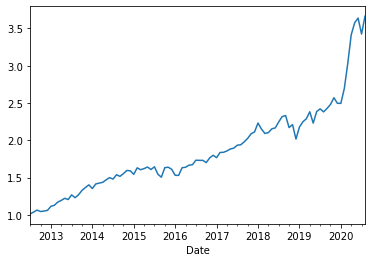

In [222]:
# Calculate cumulative return of the Random Forest model and plot the result
(1 + (Results['Percentage Return'] * Results['Random Forest Predicted Value'])).cumprod().plot()

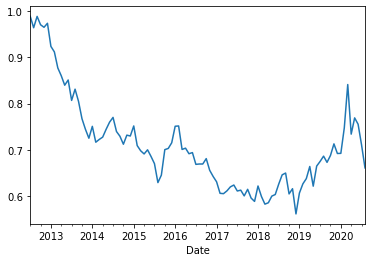

In [223]:
# Calculate cumulative return of SMOTE model and plot the result
(1 + (Results['Percentage Return'] * Results['SMOTE Predicted Value'])).cumprod().plot()

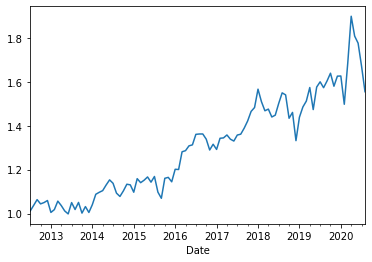

In [224]:
# Calculate cumulative return of Gradient Boosting model and plot the result
(1 + (Results['Percentage Return'] * Results['Gradient Boost Predicted Value'])).cumprod().plot()

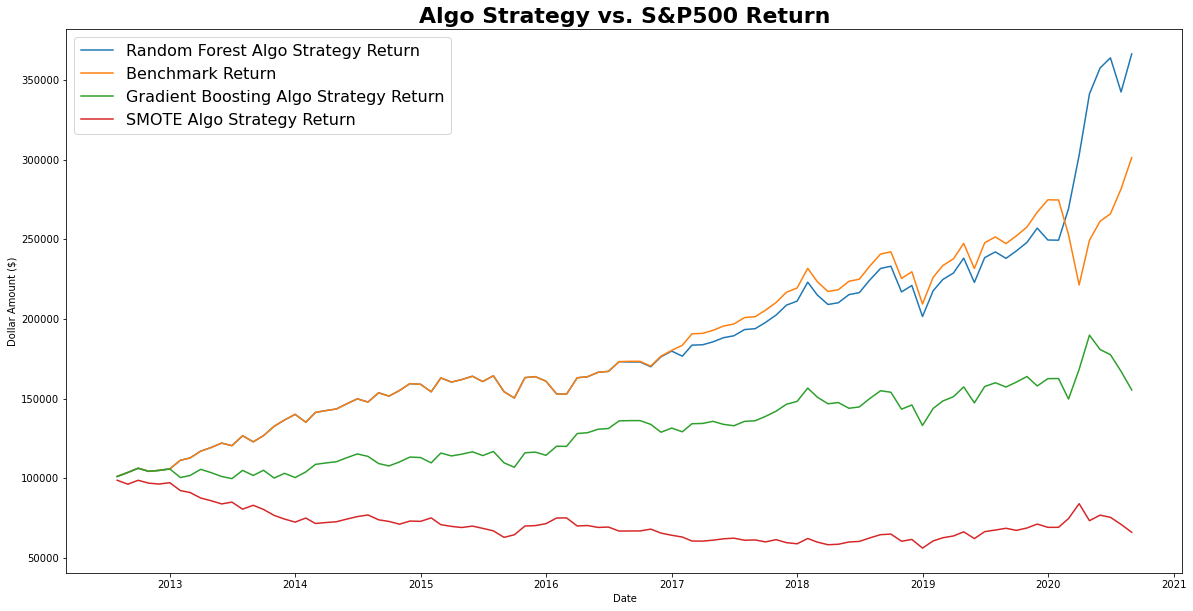

In [225]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of models in terms of capital
cumulative_RF_capital = initial_capital * (1 + (Results['Percentage Return'] * Results['Random Forest Predicted Value'])).cumprod()
benchmark_return = initial_capital * (1+(Results['Percentage Return'])).cumprod()
cumulative_gradient_return = initial_capital * (1 + (Results['Percentage Return'] * Results['Gradient Boost Predicted Value'])).cumprod()
cumulative_SMOTE_return = initial_capital * (1 + (Results['Percentage Return'] * Results['SMOTE Predicted Value'])).cumprod()
#cumulative_Logreg_return = initial_capital * (1 + (Results['Percentage Return'] * Results['Logistic Regression Predicted Value'])).cumprod()
#cumulative_RF_oversampling_return = initial_capital * (1 + (Results['Percentage Return'] * Results['Random Forest Model/Oversampling Predicted Value'])).cumprod()

# Plot the returns of the Algo strategies and the benchmark return over the testing period

plt.subplots(figsize=(20,10))
plt.plot(cumulative_RF_capital)
plt.plot(benchmark_return)
plt.plot(cumulative_gradient_return)
plt.plot(cumulative_SMOTE_return)
#plt.plot(cumulative_Logreg_return)
#plt.plot(cumulative_RF_oversampling_return)

plt.legend(["Random Forest Algo Strategy Return", 
            "Benchmark Return",
            "Gradient Boosting Algo Strategy Return", 
            "SMOTE Algo Strategy Return",
            #"Logistic Regression Algo Strategy Return",
            #"RF Model(with oversampling) Algo Strategy Return"
           ], 
           prop={'size': 16})
plt.xlabel("Date")
plt.ylabel("Dollar Amount ($)")
plt.title(f"Algo Strategy vs. S&P500 Return", fontdict={'fontweight':'bold', 'fontsize':'22'})
plt.show()